In [114]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
import rispy
from IPython.display import display

In [116]:
# Display full text in all columns
pd.set_option("display.max_colwidth", None)

# Optional: Increase the number of displayed rows and columns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

In [71]:
WOS_papers = pd.read_excel("./WOS/wos.xls")
ris_files = glob("./ScienceDirect/*.ris")
SCO_papers = pd.read_csv("./Scopus/scopus.csv")

# List to store each DataFrame
dfs = []

# Process each .ris file and append to the list of DataFrames
for ris_file in ris_files:
    with open(ris_file, "r", encoding="utf-8") as file:
        entries = rispy.load(file)  # Parse .ris file using rispy
        df = pd.DataFrame(entries)  # Convert each file to a DataFrame
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
SD_papers = pd.concat(dfs, ignore_index=True)

In [72]:
# # Merge 'Author Keywords' and 'Keywords Plus' in WOS_papers
# WOS_papers["Keywords"] = WOS_papers["Author Keywords"].fillna("") + "; " + WOS_papers["Keywords Plus"].fillna("")
# WOS_papers["Keywords"] = WOS_papers["Keywords"].str.strip("; ")

# # Merge 'Author Keywords' and 'Index Keywords' in SCO_papers
# SCO_papers["Keywords"] = SCO_papers["Author Keywords"].fillna("") + "; " + SCO_papers["Index Keywords"].fillna("")
# SCO_papers["Keywords"] = SCO_papers["Keywords"].str.strip("; ")

In [125]:
print(WOS_papers.shape[0])
print(SCO_papers.shape[0])
print(SD_papers.shape[0])

184
560
142


In [ ]:
# Rename columns to match the common fields in all dataframes
WOS_papers = WOS_papers.rename(columns={"Article Title": "Title", "Abstract": "Abstract", "Authors": "Authors", "DOI": "DOI", "ISSN": "ISSN", "Publication Year": "Publication Year"})

SCO_papers = SCO_papers.rename(columns={"Article Title": "Title", "Abstract": "Abstract", "Authors": "Authors", "DOI": "DOI", "ISSN": "ISSN", "Publication Year": "Publication Year"})

SD_papers = SD_papers.rename(columns={"primary_title": "Title", "abstract": "Abstract", "authors": "Authors", "doi": "DOI", "issn": "ISSN", "year": "Publication Year", "keywords": "Keywords"})

In [74]:
# For WOS_papers
WOS_papers["Keywords"] = WOS_papers["Author Keywords"].fillna("") + "; " + WOS_papers["Keywords Plus"].fillna("")
# Clean and convert to set format
WOS_papers["Keywords"] = WOS_papers["Keywords"].str.strip("; ").str.lower().apply(lambda x: {kw.strip() for kw in x.split(";") if kw.strip()} if isinstance(x, str) and x else set())

# For SCO_papers
SCO_papers["Keywords"] = SCO_papers["Author Keywords"].fillna("") + "; " + SCO_papers["Index Keywords"].fillna("")
# Clean and convert to set format
SCO_papers["Keywords"] = SCO_papers["Keywords"].str.strip("; ").str.lower().apply(lambda x: {kw.strip() for kw in x.split(";") if kw.strip()} if isinstance(x, str) and x else set())

# For SD_papers
# Ensure only valid lists are processed and convert to sets
SD_papers["Keywords"] = SD_papers["Keywords"].apply(lambda lst: {kw.lower().strip() for kw in lst if kw.strip()} if isinstance(lst, list) else set())

In [75]:
common_columns = ["Title", "Abstract", "Authors", "Keywords", "DOI", "ISSN", "Publication Year"]

WOS_papers_common = WOS_papers[common_columns]
SCO_papers_common = SCO_papers[common_columns]
SD_papers_common = SD_papers[common_columns]

In [76]:
print(WOS_papers_common.columns[WOS_papers_common.columns.duplicated()])
print(SCO_papers_common.columns[SCO_papers_common.columns.duplicated()])
print(SD_papers_common.columns[SD_papers_common.columns.duplicated()])

Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [77]:
combined_df = pd.concat([WOS_papers_common, SCO_papers_common, SD_papers_common], ignore_index=True)

In [78]:
combined_df.to_csv("./COMBINED.csv")

In [79]:
combined_df.shape[0]

886

In [80]:
keyword_counts = {}
for i, element in enumerate(combined_df[combined_df["Keywords"].notnull()]["Keywords"]):
    # split = element.split(";") if type(element) is str else print("FUCK FUCK", element)
    # print(split)
    for kw in element:
        kw = kw.strip().lower()
        if kw not in keyword_counts:
            keyword_counts[kw] = 1
        else:
            keyword_counts[kw] += 1

# Convert the dictionary to a DataFrame
keywords_df = pd.DataFrame(list(keyword_counts.items()), columns=["keyword", "count"])

# Sort the DataFrame by count in descending order (optional)
keywords_df = keywords_df.sort_values(by="count", ascending=False).reset_index(drop=True)

print(keywords_df)

                        keyword  count
0                      workload    123
1                    ergonomics    113
2                      workers'    105
3                      assembly    100
4                         human     79
...                         ...    ...
5259  high-temperature exposure      1
5260   environmental scientists      1
5261                     mexico      1
5262        preventive medicine      1
5263             3d interaction      1

[5264 rows x 2 columns]


In [82]:
combined_df.columns

Index(['Title', 'Abstract', 'Authors', 'Keywords', 'DOI', 'ISSN',
       'Publication Year'],
      dtype='object')

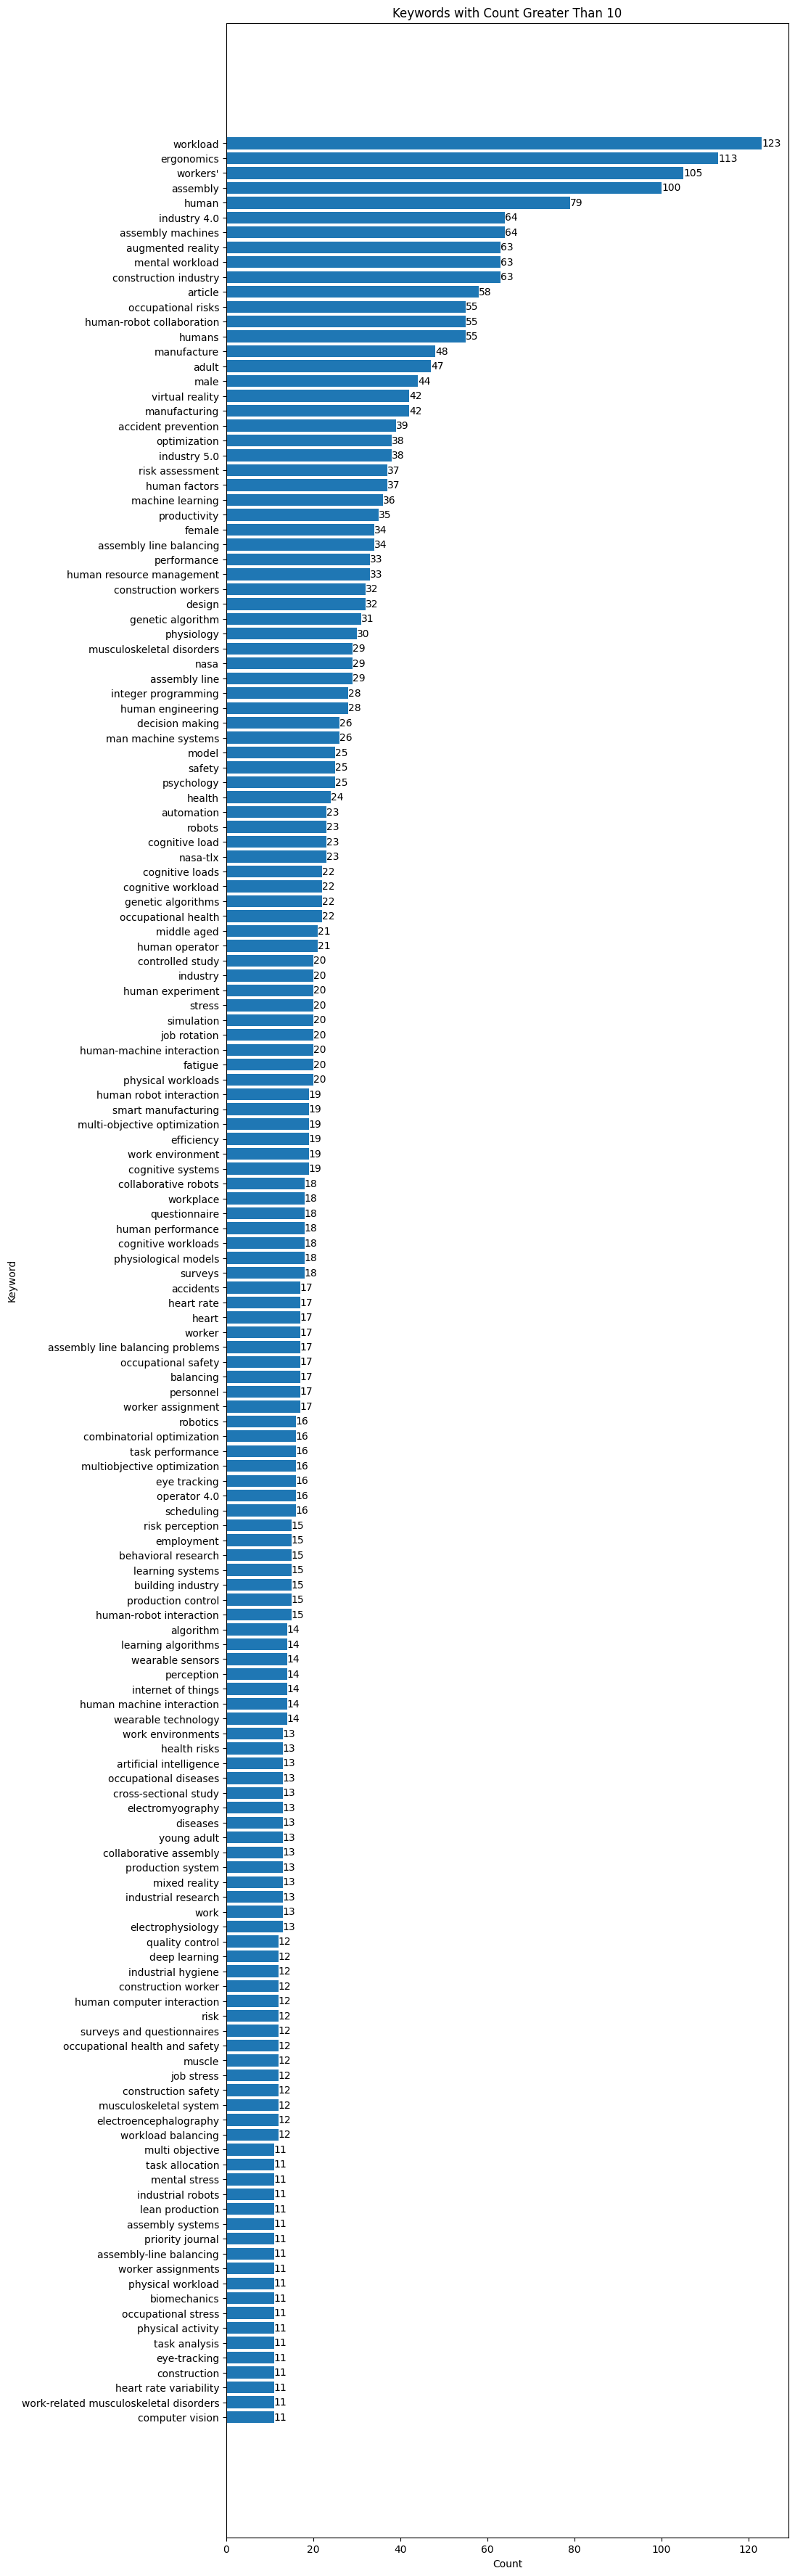

In [81]:
# Filter keywords that have a count greater than 1
keywords_df_filtered = keywords_df[keywords_df["count"] > 10]

# Plotting
plt.figure(figsize=(10, 45))
plt.barh(keywords_df_filtered["keyword"], keywords_df_filtered["count"], align="center")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.title("Keywords with Count Greater Than 10")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top

# Adding count labels at the end of each bar
for index, value in enumerate(keywords_df_filtered["count"]):
    plt.text(value, index, str(value), va="center")

plt.show()

In [136]:
# Filter rows where any keyword contains "industry" as a substring
filtered_df = combined_df[combined_df["Keywords"].apply(lambda keywords: any("cognitive" in kw for kw in keywords))]

# Display the number of matching rows and the first few rows of the filtered DataFrame
print(filtered_df.shape[0])
display(filtered_df.head())

100


,Title,Abstract,Authors,Keywords,DOI,ISSN,Publication Year
2,Experimental study to investigate mental workload of local vs remote operator in human-machine interaction,"A new Coronavirus disease 2019 has spread globally since 2019. Consequently, businesses from different sectors were forced to work remotely. At the same time, research in this area has seen a rise in studying and emerging technologies that allow and promote such a remote working style; not every sector is equipped for such a transition. The manufacturing sector especially, has faced challenges in this respect. This paper investigates the mental workload (MWL) of two groups of participants through a human-machine interaction task. Participants were required to bring a robotised cell to full production by tuning system and dispensing process parameters. Following the experiment, a self-assessment of the participants' perceived MWL using the raw NASA Task Load Index (RTLX) was collected. The results reveal that remote participants tend to have a lower perceived workload compared to the local participants, but mental demand was deemed higher while performance was rated lower.","Zimmer, M; Al-Yacoub, A; Ferreira, P; Hubbard, EM; Lohse, N","{ergonomics, human-machine interaction, cognitive load assessment, mental workload, rtlx, nasa-tlx, collaboration, remote working, visual information}",10.1080/21693277.2022.2090458,NaN,2022
6,On the development of a method for cognitive load assessment in manufacturing,"The increasing complexity and demands of assembly operations in manufacturing has been shown to lead to increased cognitive load in assembly workers. Previous work has outlined the complexity of an assembly worker's situation both in terms of difficulty and speed of work and there have been a few attempts at creating frameworks and methods for understanding the key aspects of what creates increased cognitive load. This paper presents the development of an analytic method, denoted CLAM (Cognitive Load Assessment for Manufacturing), and a tool for assessing cognitive load in manufacturing, primarily assembly. It outlines the journey of the development as well as discusses and problematizes relevant meta-methodological issues paired with method development. The intended contribution of the work is to make a difference in reducing the cognitive load of assembly workers on the shop floor, thus focusing the development on applicability and usability of the tool in practice. With this purpose in mind, focus of the method development has been on the practitioners, i.e. the method should not require any expert knowledge to be applied. The CLAM method and accompanying documentation such as a handbook containing instructions towards using the method and interpreting the results, is available in an online tool.","Thorvald, P; Lindblom, J; Andreasson, R","{cognitive load, mental workload, manufacturing, clam method, design, assembly, method development}",10.1016/j.rcim.2019.04.012,0736-5845,2019
10,Overloaded and at Work: Investigating the Effect of Cognitive Workload on Assembly Task Performance,"Objective This study investigates the effect of cognitive overload on assembly task performance and muscle activity. Background Understanding an operator's cognitive workload is an important component in assessing human-machine interaction. However, little evidence is available on the effect that cognitive overload has on task performance and muscle activity when completing manufacturing tasks. Method Twenty-two volunteers completed an assembly task while performing a secondary cognitive task with increasing levels of demand (n-back). Performance in the assembly task (completion times, accuracy), muscle activity recorded as integrated electromyography (EMG), and self-reported workload were measured. Results Results show that the increasing cognitive demand imposed by then-back task resulted in impaired assembly task performance, overall greater muscle activity, and higher self-report

In [143]:
# Define the list of search terms
search_terms = ["cognitive load", "manufacturing"]

# Filter rows where any term appears in Keywords, Title, or Abstract
filtered_df = combined_df[combined_df["Keywords"].apply(lambda keywords: any(term in kw for kw in keywords for term in search_terms)) | 
                          combined_df["Title"].apply(lambda title: any(term.lower() in title.lower() for term in search_terms) if pd.notnull(title) else False) | combined_df["Abstract"].apply(lambda abstract: any(term.lower() in abstract.lower() for term in search_terms) if pd.notnull(abstract) else False)]

# Display the number of matching rows and the first few rows of the filtered DataFrame
print(filtered_df.shape[0])
display(filtered_df.head())

423


,Title,Abstract,Authors,Keywords,DOI,ISSN,Publication Year
2,Experimental study to investigate mental workload of local vs remote operator in human-machine interaction,"A new Coronavirus disease 2019 has spread globally since 2019. Consequently, businesses from different sectors were forced to work remotely. At the same time, research in this area has seen a rise in studying and emerging technologies that allow and promote such a remote working style; not every sector is equipped for such a transition. The manufacturing sector especially, has faced challenges in this respect. This paper investigates the mental workload (MWL) of two groups of participants through a human-machine interaction task. Participants were required to bring a robotised cell to full production by tuning system and dispensing process parameters. Following the experiment, a self-assessment of the participants' perceived MWL using the raw NASA Task Load Index (RTLX) was collected. The results reveal that remote participants tend to have a lower perceived workload compared to the local participants, but mental demand was deemed higher while performance was rated lower.","Zimmer, M; Al-Yacoub, A; Ferreira, P; Hubbard, EM; Lohse, N","{ergonomics, human-machine interaction, cognitive load assessment, mental workload, rtlx, nasa-tlx, collaboration, remote working, visual information}",10.1080/21693277.2022.2090458,NaN,2022
3,Social sustainability in manufacturing system: case of multi-manned assembly line,"The manufacturing sector has always been at the heart of technological advances. In the manufacturing setting, labor's variety addresses a critical challenge for organizations, particularly those characterized by high worker turnover and manual cycles that involve high physical workload like in assembly lines. In this paper, sustainability is addressed in the manufacturing system especially in assembly lines. It is known with its 3 aspects: social, economic and environmental. In this study, social aspect is treated by considering the worker's tiredness in assembly lines. To explain the problem, an illustrative example is given to show the importance of the worker's tiredness in determining their salaries. Two distinct assignment scenarios are examined revealing that opting for a specific type of resource results in cost savings compared to utilizing diverse resources. Additionally, this last choice enhances the operator's working comfort.","Tkitek, Z; Triki, H; Moalla, HF","{sustainability, assembly line balancing, manufacturing, multi-manned assembly line, social aspect}",10.1109/IC_ASET61847.2024.10596228,NaN,2024
4,Formalizing Human-Machine Interactions for Adaptive Automation in Smart Manufacturing,"Human-machine interaction is one of the most crucial aspects of advanced manufacturing systems that have advanced to so-called smart manufacturing systems. In this regard, this paper presents a framework for formalizing human-machine manufacturing systems. The human-machine system considered in this paper consists of the following three main components: a human supervisor; several cells, each of which is composed of a human operator and a machine; and interfaces. A human operator interacts with a machine in a cell and performs manufacturing tasks based on commands given by the supervisor. Meanwhile, the supervisor is responsible for performing exception handling tasks in response to unanticipated events reported by the cells. With the proposed model, desirable specifications are constructed, which include a condition free of mode confusion, manufacturing task goal reachability, and exception handling task supportability in human-machine manufacturing systems. It is also suggested that adaptive automation with varying levels of information abstraction to humans can be accommodated by the proposed framework. As an illustrative example, we demonstrate the formal models and specifications and the applicability of adaptive automation with a case study of a simple ch